<a href="https://colab.research.google.com/github/MhmdSafa7/Helmet_Detection_yolo/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import shutil

base_path = '/content/drive/MyDrive/Colab Notebooks/Helmet_Data'
annotations_path = os.path.join(base_path, 'annotations')
images_path = os.path.join(base_path, 'images')

yolo_dataset_path = os.path.join(base_path, 'yolo_dataset')
os.makedirs(yolo_dataset_path, exist_ok=True)



In [5]:
import os
import xml.etree.ElementTree as ET

CLASS_NAMES = ["helmet", "person", "head"]

# Work locally instead of directly in Drive
yolo_dataset_path = '/content/yolo_dataset'
annotations_path = '/content/drive/MyDrive/Colab Notebooks/Helmet_Data/annotations'
os.makedirs(yolo_dataset_path, exist_ok=True)
output_labels_dir = os.path.join(yolo_dataset_path, "labels")
os.makedirs(output_labels_dir, exist_ok=True)

def convert_voc_to_yolo(xml_file, output_dir):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    if size is None:  # if file missing size info
        return
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    file_name = os.path.splitext(os.path.basename(xml_file))[0] + ".txt"
    with open(os.path.join(output_dir, file_name), "w") as out_file:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in CLASS_NAMES:
                continue
            cls_id = CLASS_NAMES.index(cls)

            xml_box = obj.find('bndbox')
            xmin = float(xml_box.find('xmin').text)
            ymin = float(xml_box.find('ymin').text)
            xmax = float(xml_box.find('xmax').text)
            ymax = float(xml_box.find('ymax').text)

            x_center = (xmin + xmax) / (2.0 * w)
            y_center = (ymin + ymax) / (2.0 * h)
            width = (xmax - xmin) / w
            height = (ymax - ymin) / h

            out_file.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Convert XMLs locally
for xml_file in os.listdir(annotations_path):
    if xml_file.endswith(".xml"):
        convert_voc_to_yolo(os.path.join(annotations_path, xml_file), output_labels_dir)

# Then copy the final dataset back to Drive safely
!cp -r /content/yolo_dataset /content/drive/MyDrive/Colab\ Notebooks/Helmet_Data/
print("✅ Conversion done and copied to Drive!")


✅ Conversion done and copied to Drive!


In [16]:
from sklearn.model_selection import train_test_split
import random

images = [f for f in os.listdir(images_path) if f.endswith('.jpg') or f.endswith('.png')]

train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

splits = {'train': train_imgs, 'val': val_imgs, 'test': test_imgs}

for split, imgs in splits.items():
    img_dir = os.path.join(yolo_dataset_path, split, 'images')
    lbl_dir = os.path.join(yolo_dataset_path, split, 'labels')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)

    for img_name in imgs:
        shutil.copy(os.path.join(images_path, img_name), img_dir)
        txt_name = os.path.splitext(img_name)[0] + ".txt"
        src_label = os.path.join(output_labels_dir, txt_name)
        if os.path.exists(src_label):
            shutil.copy(src_label, lbl_dir)


AttributeError: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metrics.
        clear_stats: Clear the stored statistics.
        keys: Return a list of keys for accessing specific metrics.
        mean_results: Calculate mean of detected objects & return precision, recall, mAP50, and mAP50-95.
        class_result: Return the result of evaluating the performance of an object detection model on a specific class.
        maps: Return mean Average Precision (mAP) scores per class.
        fitness: Return the fitness of box object.
        ap_class_index: Return the average precision index per class.
        results_dict: Return dictionary of computed performance metrics and statistics.
        curves: Return a list of curves for accessing specific metrics curves.
        curves_results: Return a list of computed performance metrics and statistics.
        summary: Generate a summarized representation of per-class detection metrics as a list of dictionaries.
    

In [7]:
yaml_content = f"""
train: {yolo_dataset_path}/train/images
val: {yolo_dataset_path}/val/images
test: {yolo_dataset_path}/test/images

nc: {len(CLASS_NAMES)}
names: {CLASS_NAMES}
"""

with open(os.path.join(yolo_dataset_path, "data.yaml"), "w") as f:
    f.write(yaml_content)

print("✅ data.yaml created successfully!")


✅ data.yaml created successfully!


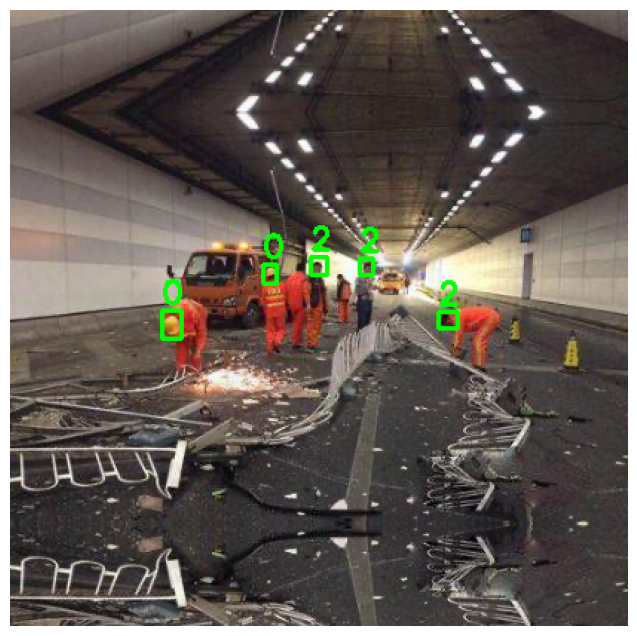

In [8]:
import cv2
import matplotlib.pyplot as plt
import os

img_dir = '/content/yolo_dataset/train/images'
lbl_dir = '/content/yolo_dataset/train/labels'

img_name = os.listdir(img_dir)[0]  # show one example
img_path = os.path.join(img_dir, img_name)
label_path = os.path.join(lbl_dir, os.path.splitext(img_name)[0] + '.txt')

# Read image
img = cv2.imread(img_path)
h, w = img.shape[:2]

# Draw boxes
with open(label_path, 'r') as f:
    for line in f.readlines():
        cls, x, y, bw, bh = map(float, line.strip().split())
        x1 = int((x - bw / 2) * w)
        y1 = int((y - bh / 2) * h)
        x2 = int((x + bw / 2) * w)
        y2 = int((y + bh / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, str(int(cls)), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

# Show
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [9]:
import os
from collections import Counter

labels_path = '/content/yolo_dataset/train/labels'
counter = Counter()

for label_file in os.listdir(labels_path):
    with open(os.path.join(labels_path, label_file), 'r') as f:
        for line in f:
            cls_id = int(line.strip().split()[0])
            counter[cls_id] += 1

print("Class counts:", counter)


Class counts: Counter({0: 13324, 2: 4073, 1: 512})


In [11]:

!pip install ultralytics
from ultralytics import YOLO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [13]:
# Load a pre-trained YOLOv8n model
model = YOLO('yolov8n.pt')

# Train the model using the 'data.yaml' file
results = model.train(data=os.path.join(yolo_dataset_path, "data.yaml"), epochs=50, imgsz=640, batch=16)

print("✅ YOLOv8 model training complete!")

Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

After training, you should evaluate your model to see how well it performs. You can use the `validate()` method for this.

In [14]:
# Evaluate the model
results = model.val()

Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3291.4±1084.4 MB/s, size: 261.2 KB)
val: Scanning /content/yolo_dataset/val/labels.cache... 1005 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1005/1005 2.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 4.2it/s 15.0s
                   all       1005       5097      0.614      0.593      0.635      0.427
                helmet        918       3832      0.945      0.895       0.96       0.64
                person         34        167          0          0     0.0218     0.0104
                  head        176       1098      0.897      0.883      0.924       0.63
Speed: 2.1ms preprocess, 4.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/runs/detect/val


In [18]:
# results from model.val()
metrics = results.results_dict  # dictionary of metrics

for k, v in metrics.items():
    print(f"{k}: {v}")


metrics/precision(B): 0.6141645716974379
metrics/recall(B): 0.5926513095904378
metrics/mAP50(B): 0.6353761782469783
metrics/mAP50-95(B): 0.4268677741498924
fitness: 0.4268677741498924



image 1/1 /content/yolo_dataset/val/images/hard_hat_workers2978.png: 640x640 2 helmets, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


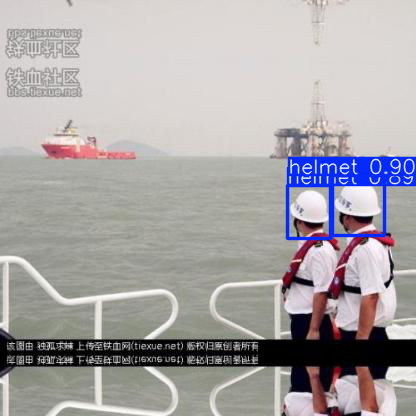


image 1/1 /content/yolo_dataset/val/images/hard_hat_workers2933.png: 640x640 6 helmets, 7.3ms
Speed: 4.8ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


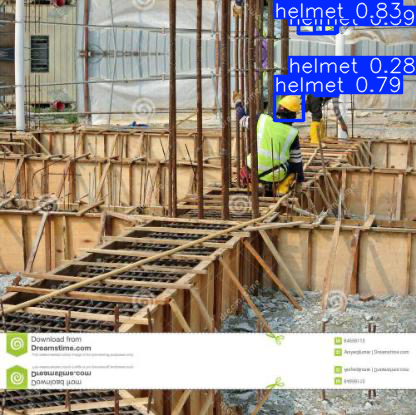


image 1/1 /content/yolo_dataset/val/images/hard_hat_workers4887.png: 640x640 9 helmets, 7.8ms
Speed: 3.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


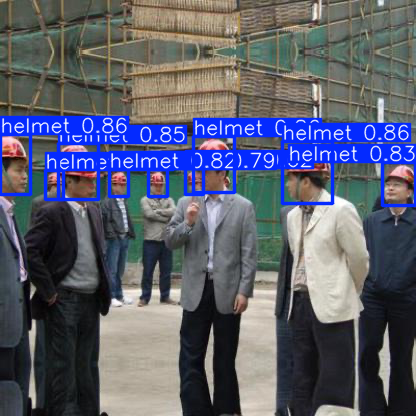


image 1/1 /content/yolo_dataset/val/images/hard_hat_workers1907.png: 640x640 4 helmets, 8.8ms
Speed: 3.5ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


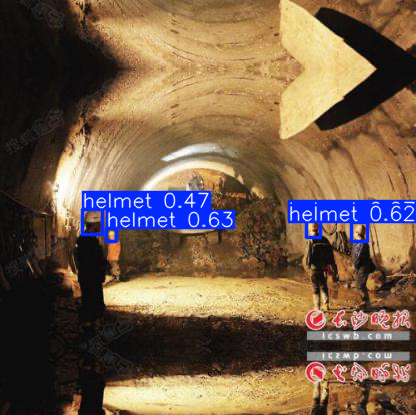


image 1/1 /content/yolo_dataset/val/images/hard_hat_workers1651.png: 640x640 2 helmets, 9.4ms
Speed: 3.4ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


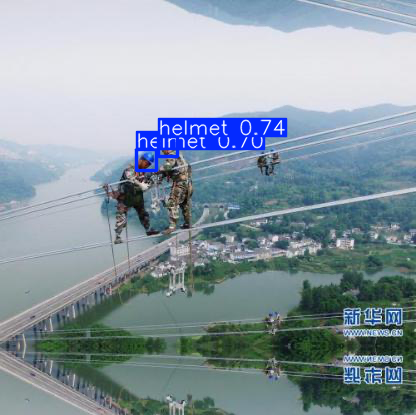

In [23]:
import random
from pathlib import Path
from matplotlib import pyplot as plt
import cv2

val_path = "/content/yolo_dataset/val/images/"
val_images = list(Path(val_path).glob("*.*"))

# Pick 5 random images
sample_imgs = random.sample(val_images, 5)

for img_path in sample_imgs:
    # Predict (returns a list of Results)
    results = model.predict(source=str(img_path))

    # Access first result
    res = results[0]

    # Show results with bounding boxes
    res.show()




